## define model

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report

class baseline(object):
        
    def __init__(self, df, companies, time_range):
        
        class StockDataset(Dataset):
            def __init__(self, X, y, transform=None, target_transform=None):
                self.X = X
                self.y = y
                self.transform = transform
                self.target_transform = target_transform

            def __len__(self):
                return len(self.y)

            def __getitem__(self, idx):
                return self.X[idx].T, self.y[idx].T

        class model_class(nn.Module):
            def __init__(self, IMPUT_DIM):
                super(model_class, self).__init__()
                self.fc1 = nn.Linear(IMPUT_DIM, 32)
                self.fc2 = nn.Linear(32, 16)
                self.fc3 = nn.Linear(16, 1)

            def forward(self, x):
                x = self.fc1(x)
                x = self.fc2(x)
                x = self.fc3(x)
                return torch.sigmoid(x)
        
        self.df = df
        self.df["Year"] = self.df.Date.dt.year
        self.df["Quarter"] = self.df.Date.dt.quarter
        self.df["Month"] = self.df.Date.dt.month
        self.df["Week"] = self.df.Date.dt.isocalendar().week
        self.companies = companies
        self.time_range = time_range
        
        self.train_df = df[df.Date < "2020-10-01"].copy()
        self.val_df = df[df.Date >= "2020-10-01"].copy()

        self.train_X, self.train_y = self._split_data(self.train_df, companies, time_range)
        self.val_X, self.val_y = self._split_data(self.val_df, companies, time_range)

        self.train_ds = StockDataset(self.train_X, self.train_y)
        self.val_ds = StockDataset(self.val_X, self.val_y)

        self.train_dl = DataLoader(self.train_ds, batch_size = 1, shuffle=True)
        self.val_dl = DataLoader(self.val_ds, batch_size = 1, shuffle=True)
        self.IMPUT_DIM = self.train_X.shape[1]
        
        self.model = model_class(self.IMPUT_DIM)
        
        self.EPOCH = 50
        self.LEARN_RATE = 0.0001
        self.OPTIM = torch.optim.Adam(self.model.parameters(), self.LEARN_RATE)
        self.LOSS = nn.BCELoss()
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def _split_data(self, df, companies, time_range):
        """Split data based on range (Quarter, Month, Week)"""
        
        if time_range not in ("Quarter", "Month", "Week"):
            raise ValueError("Please indicate data range (Quarter, Month, or Week)")

        n = len(companies)
        X = [df.groupby(["Year", time_range]).get_group(x)[companies].to_numpy() \
            for x in df.groupby(["Year", time_range]).groups]
        len_data = max([len(X[i]) for i in range(len(X))])
        X = [np.pad(X[i], ((len_data-X[i].shape[0],0), (0,0)), "mean") for i in range(len(X))]
        curr_mean = np.array([X[i].mean(axis=0) for i in range(len(X))])
        y = (np.diff(curr_mean, axis=0) > 0).astype(int)
        X = X[:-1]

        return np.array(X).astype(np.float32), np.array(y).astype(np.float32)
    
    def _training_loop(self, epochs, optimizer, model, loss_f, train_loader, val_loader, device):
        """Train baseline model"""
        
        for epoch in tqdm(range(epochs), position=0, leave=True):
            loss_train = 0.0
            for x, y in train_loader:
                out = model(x.to(device=device))
                loss = loss_f(out, y.to(device=device).unsqueeze(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()

            if epoch % 10 == 0 or epoch == epochs - 1:
                loss_val = 0.0         
                for x, y in val_loader:
                    out = model(x.to(device=device))
                    loss = loss_f(out, y.to(device=device).unsqueeze(-1))
                    loss_val += loss.item()
                print(
                    epoch, "Training Loss:", loss_val/len(val_loader),
                    "Validation Loss:", loss_train/len(train_loader)
                )
    
    def _val_loop(self, model, val_loader, device):
        
        preds = []
        trues = []
        
        for x, y in val_loader:
            out = model(x.to(device=device)).detach().numpy().reshape(len(self.companies),)
            out = (out > 0.5).astype(int).tolist()
            y = y.detach().numpy().reshape(len(self.companies),).tolist()
            preds += out
            trues += y
        
        return classification_report(trues, preds)
                
    def train(self):
        self._training_loop(self.EPOCH, self.OPTIM, self.model, self.LOSS, self.train_dl, self.val_dl, self.DEVICE)
        
    def validate(self):
        return self._val_loop(self.model, self.val_dl, self.DEVICE)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from pandas.plotting import autocorrelation_plot
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error

## load data

In [3]:
df = pd.read_csv('../data/raw/stock/raw.csv')
df = df[["Date", "Close", "ticker_symbol"]]
df = df.pivot(index="Date", columns="ticker_symbol", values="Close").reset_index()
df["Date"] = df.Date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df.head()

ticker_symbol,Date,aapl,amgn,axp,ba,cat,crm,csco,cvx,dis,...,mrk,msft,nke,pg,trv,unh,v,vz,wba,wmt
0,2016-10-03,28.129999,167.339996,63.810001,132.380005,88.279999,70.519997,31.500000,102.449997,92.489998,...,59.656490,57.419998,52.669998,88.660004,113.000000,138.490005,82.860001,51.880001,80.379997,72.010002
1,2016-10-04,28.250000,167.550003,63.910000,132.250000,87.510002,72.629997,31.350000,101.269997,92.589996,...,59.599236,57.240002,52.139999,88.349998,112.320000,138.160004,82.730003,51.259998,80.239998,71.750000
2,2016-10-05,28.262501,167.240005,64.360001,134.660004,89.419998,68.419998,31.590000,102.230003,92.449997,...,59.923664,57.639999,52.119999,88.849998,113.099998,137.600006,83.349998,50.270000,80.510002,71.669998
3,2016-10-06,28.472500,166.899994,61.939999,134.419998,89.290001,71.260002,31.480000,102.180000,92.830002,...,59.790077,57.740002,52.029999,89.220001,113.180000,136.470001,83.360001,50.259998,80.300003,69.360001
4,2016-10-07,28.514999,167.500000,61.759998,133.850006,88.470001,70.910004,31.469999,102.269997,92.489998,...,59.895039,57.799999,51.790001,90.000000,114.529999,136.660004,82.879997,49.919998,79.879997,68.699997


## visualization

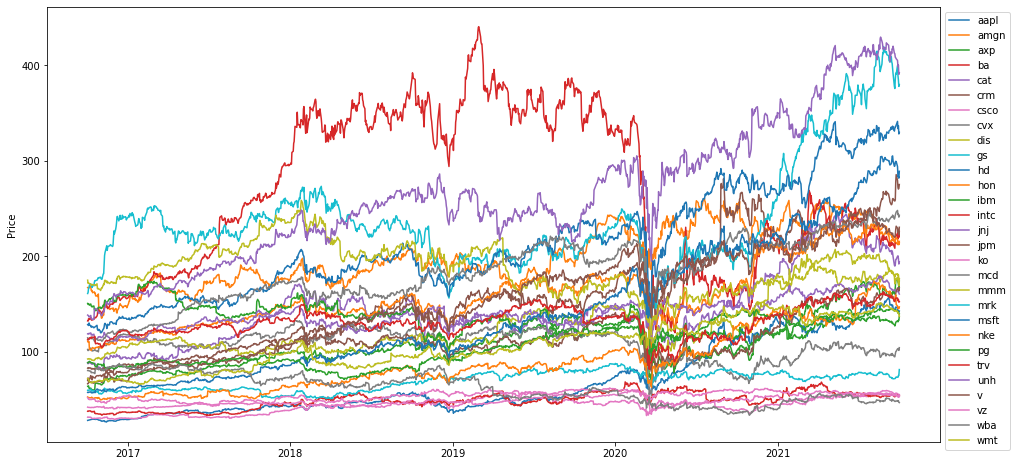

In [4]:
symbols = list(df.columns[1:])
plt.figure(figsize=(16,8))
for company in symbols:
    plt.plot(df.Date, df[company], label=company)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Price")
plt.show()

In [5]:
companies = [
    'aapl', 'amgn', 'axp', 'ba', 'cat', 'crm', 'csco', 'cvx', 'dis',
    'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'ko', 'mcd', 'mmm',
    'mrk', 'msft', 'nke', 'pg', 'trv', 'unh', 'v', 'vz', 'wba', 'wmt'
]

## Quarter

In [6]:
bs = baseline(df, companies, "Quarter")
bs.train()

  0%|          | 0/50 [00:00<?, ?it/s]

0 Training Loss: 1.129339575767517 Validation Loss: 8.026993278662363
10 Training Loss: 0.905364528298378 Validation Loss: 0.8268318176269531
20 Training Loss: 0.7270938530564308 Validation Loss: 0.7638841907183329
30 Training Loss: 0.5733972117304802 Validation Loss: 0.6551446715990702
40 Training Loss: 0.5675582736730576 Validation Loss: 0.6185635010401408
49 Training Loss: 0.659652441740036 Validation Loss: 0.6181897113720576


In [7]:
print(bs.validate())

              precision    recall  f1-score   support

         0.0       0.47      0.88      0.61        42
         1.0       0.86      0.43      0.58        74

    accuracy                           0.59       116
   macro avg       0.67      0.66      0.59       116
weighted avg       0.72      0.59      0.59       116



## Month

In [8]:
bs = baseline(df, companies, "Month")
bs.train()

  0%|          | 0/50 [00:00<?, ?it/s]

0 Training Loss: 0.81208602587382 Validation Loss: 0.7706949482572839
10 Training Loss: 0.6536409755547842 Validation Loss: 0.6793285811201055
20 Training Loss: 0.6449775795141856 Validation Loss: 0.6081188251363471
30 Training Loss: 0.6403452455997467 Validation Loss: 0.6173543245234387
40 Training Loss: 0.7083502461512884 Validation Loss: 0.6016560830968491
49 Training Loss: 0.7396858607729276 Validation Loss: 0.6078732527316885


In [9]:
print(bs.validate())

              precision    recall  f1-score   support

         0.0       0.46      0.95      0.62       126
         1.0       0.93      0.37      0.53       222

    accuracy                           0.58       348
   macro avg       0.70      0.66      0.58       348
weighted avg       0.76      0.58      0.56       348

